In [1]:
#import
import boto3
import os
from datetime import datetime, timezone
import shutil
import configparser
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from PIL import Image

import io

In [2]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the .cfg file
config.read('aws_key.cfg')

# Accessing the values
# Access a specific section
settings = config['Secrets']

#DO NOT PRINT secret access key or key id
session = boto3.Session(
    aws_access_key_id=settings['aws_access_key_id'],
    aws_secret_access_key=settings['aws_secret_access_key'],
)

s3 = session.client('s3')

In [3]:
# Call S3 to list current buckets
response = s3.list_buckets()

# Get a list of all bucket names from the response and print them
bucket_names = [bucket['Name'] for bucket in response['Buckets']]

print(bucket_names)

# Pagination configuration
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket='mv1-production')

['aged-raw-imports', 'dev-jackie-bucket', 'gif-bucket-drew', 'henry-metadata-testing', 'iot-test-buckets', 'micds', 'ml-v043-micds-01', 'ml-v043-micds-02', 'ml-v043-micds-03', 'ml-v043-micds-04', 'ml-v043-micds-05', 'ml-v043-testing-01', 'mm-v021-asa-1', 'mm-v021-asa-1-backup', 'mm-v021-asa-2', 'mm-v021-asa-3', 'mm-v021-asa-4', 'mm-v021-asa-5', 'mm-v021-asa-6', 'mm-v021-asa-7', 'mm-v021-bgc-1', 'mm-v021-bgc-1-backup', 'mm-v021-globalimpactacademy-1', 'mm-v021-marsfarmtesting-1', 'mm-v021-nburlingtonmiddleschool-1', 'mm-v021-scc-1', 'mm-v021-scc-1-backup', 'mm-v021-scc-2', 'mm-v021-scc-3', 'mm-v021-stjoeshighschool-1', 'mm-v021-stjoeshighschool-2', 'mm-v021-stjoeshighschool-backup', 'mm-v023-asa-01', 'mm-v023-asa-02', 'mm-v023-asa-03', 'mm-v023-asa-04', 'mm-v023-asa-05', 'mm-v023-asa-06', 'mm-v023-asa-07', 'mm-v023-asa-08', 'mm-v023-asa-09', 'mm-v023-asa-10', 'mm-v023-asa-11', 'mm-v023-asa-12', 'mm-v023-asa-13', 'mm-v023-asa-14', 'mm-v023-asa-15', 'mm-v023-asa-16', 'mm-v023-asa-17', 'mm

In [4]:
# Function to process and download images
def process_and_download_images(response):
    if 'Contents' in response:
        for obj in response['Contents']:
            return obj['Size']

In [5]:
def list_folders_in_bucket(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')

    folders = set()
    # Use the paginator to handle buckets with many items

    for page in paginator.paginate(Bucket=bucket_name):
        # Filter for 'folders' by checking if the key ends with a '/'
        if 'Contents' in page:
            for obj in page.get('Contents', []):
                key = obj['Key']
                if '/' in key:
                    folder = key.rsplit('/', 1)[0] + '/'
                    folders.add(folder)

    return folders
#LOT OF FOLDERS
#print(list_folders_in_bucket('mv1-production'))

In [6]:
def count_images_in_bucket(bucket_name):
    # Supported image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']
    
    # Initialize a counter
    image_count = 0
    
    # Paginator to handle buckets with many objects
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)
    
    # Iterate through each object in the bucket
    def is_image(obj_key):
        image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']
        return any(obj_key.lower().endswith(ext) for ext in image_extensions)

    keys = []
    for page in page_iterator:
        if 'Contents' in page:
            keys.extend([obj['Key'] for obj in page['Contents']])

    with ThreadPoolExecutor() as executor:
        image_count = executor.map(is_image, keys)
    return sum(image_count)

#mv1 actively accumulates images over time
print(count_images_in_bucket('mm-v023-regini-01'))

654


In [7]:
def get_metadata(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket_name):
        # Each page is a dictionary that contains a list of objects under 'Contents'
        for obj in page.get('Contents', []):
            response = s3.head_object(Bucket=bucket_name, Key=obj['Key'])
            metadata = response.get('Metadata', {})
            
            print(response)

#get_metadata('mm-v023-regini-01')       

In [8]:
#mm-v023-regini-01 bucket only
# Initialize the S3 client outside of the function if it's used across multiple functions
def get_unique_file_types(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)

    file_types = set()

    for page in page_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                _, ext = os.path.splitext(obj['Key'])
                if ext:  # Ensure there is an extension
                    file_types.add(ext.lower())

    return file_types
get_unique_file_types('mm-v023-backup')

{'.jpg'}

{}


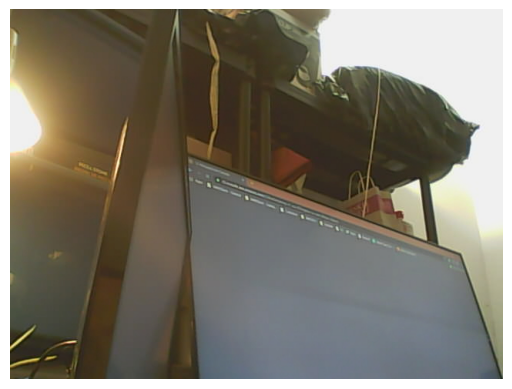

In [30]:
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt

#function to tst loading an image directly from s3
def display_first_image_with_opencv(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']

    for page in page_iterator:
        for obj in page.get('Contents', []):
            if any(obj['Key'].lower().endswith(ext) for ext in image_extensions):
                response = s3.get_object(Bucket=bucket_name, Key=obj['Key'])
                image_data = response['Body'].read()
                print(response['Metadata'])
                
                # Load the image data into a PIL Image object
                image = Image.open(io.BytesIO(image_data))
            
                # Convert the PIL Image to a NumPy array
                image_np = np.array(image)
            
                # Plot the image
                plt.imshow(image_np)
                plt.axis('off')  # Hide axis
                plt.show()
                
                # Display the image            
                return
    print("No images found in the bucket.")

display_first_image_with_opencv('mvp-v1-asa-06')


{}


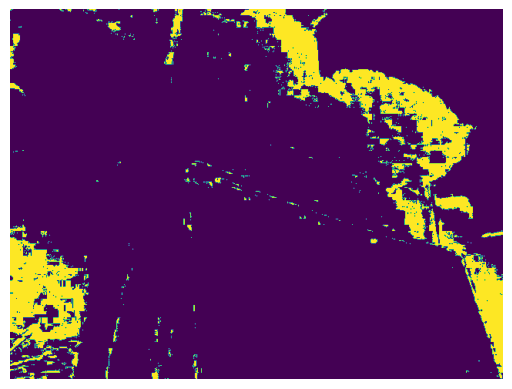

35294


In [31]:
#test out opening an image using opencv and checking if it has a plant in it
def check_if_has_plant_s3(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name)
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.svg']

    for page in page_iterator:
        for obj in page.get('Contents', []):
            if any(obj['Key'].lower().endswith(ext) for ext in image_extensions):
                response = s3.get_object(Bucket=bucket_name, Key=obj['Key'])
                image_data = response['Body'].read()
                print(response['Metadata'])
                
                # Load the image data into a PIL Image object
                image = Image.open(io.BytesIO(image_data))
            
                # Convert the PIL Image to a NumPy array
                image_np = np.array(image)
            
                # Plot the image
                # Convert the image from RGB to HSV
                hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
                
                # Define the range of green color in HSV
                # Adjusted range of green color in HSV to reduce false positives
                lower_green = np.array([25, 40, 40])
                upper_green = np.array([95, 255, 255])
                
                # Threshold the HSV image to get only green colors
                mask = cv2.inRange(hsv, lower_green, upper_green)
                # Plot the image
                plt.imshow(mask)
                plt.axis('off')  # Hide axis
                plt.show()
                count_non_black = cv2.countNonZero(mask)
                print(count_non_black)
                
                # Display the image            
                return
    print("No images found in the bucket.")

check_if_has_plant_s3('mvp-v1-asa-06')